In [7]:
pip install folium


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib seaborn plotly pandas numpy

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 40.2 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib seaborn pandas numpy plotly

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


------------------------------------------------------------------------
              SMART CARE FOR STRAY ANIMALS           
------------------------------------------------------------------------


Enter the place/ward name (e.g., Banashankari):  Banashankari


*Search Result: 'Banashankari' maps to Zone: Bengaluru South*

--- Risk Analysis for Zone: Bengaluru South ---
Overall Classification: *LOW RISK (Score: -0.7603)*

[OVERALL JUSTIFICATION]
The zone is structurally safe due to: Strong Animal Control (High Neutering: 0.7732). Low Animal Density (Ratio: 0.0129). High Public Safety Infrastructure (Police Stations: 42).

[FEATURE CONTRIBUTION (vs. Average Zone)]
Animal/Human Ratio       : Lower (0.0129 vs Avg 0.0292). *Mitigating Factor.*
Neutered Rate (Decimal)  : Higher (0.7732 vs Avg 0.7146). *Strong Mitigator.*
Households               : Lower (427494.0000 vs Avg 501748.8750). *Mitigating Factor.*
Actual Accidents         : Higher (1726.0000 vs Avg 1516.0000). *Major Risk Contributor.*
NGO/Orgs Count           : Higher (2.0000 vs Avg 2.0000). *Strong Mitigator.*
Vet Hospitals Count      : Lower (11.0000 vs Avg 13.0000). *Weak Mitigator / Risk Contributor.*
Police Stations Count    : Higher (42.0000 vs Avg 24.0000). *Strong Mitigator.*


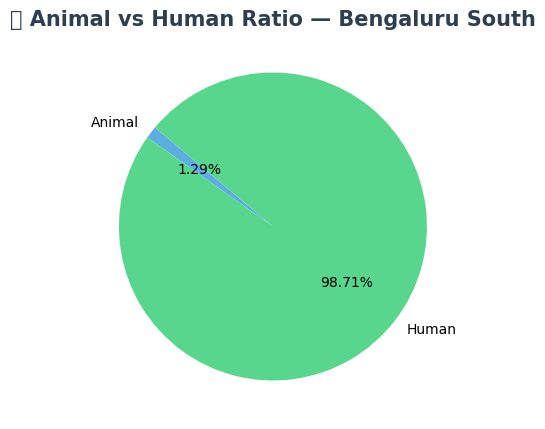

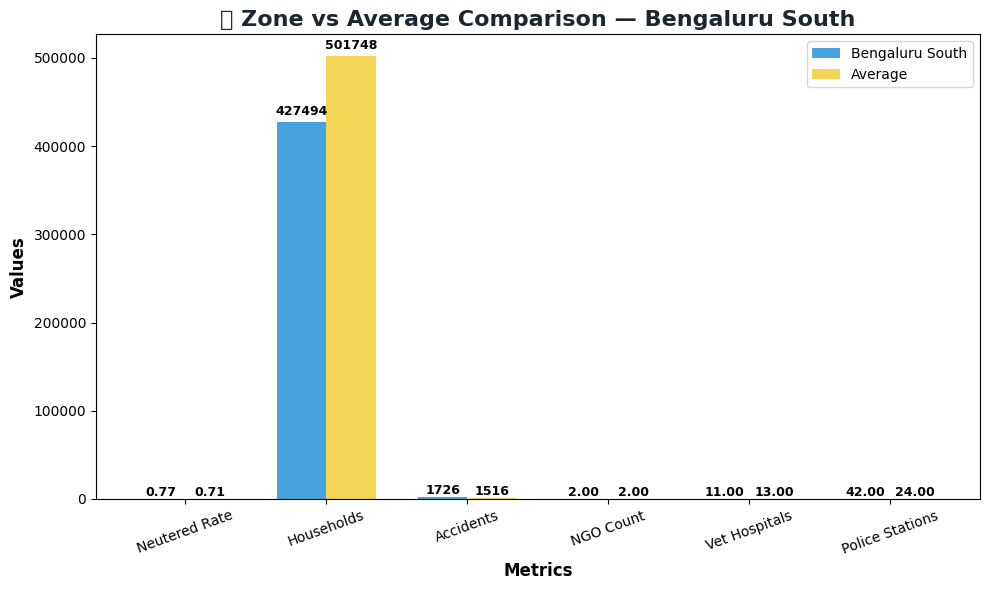

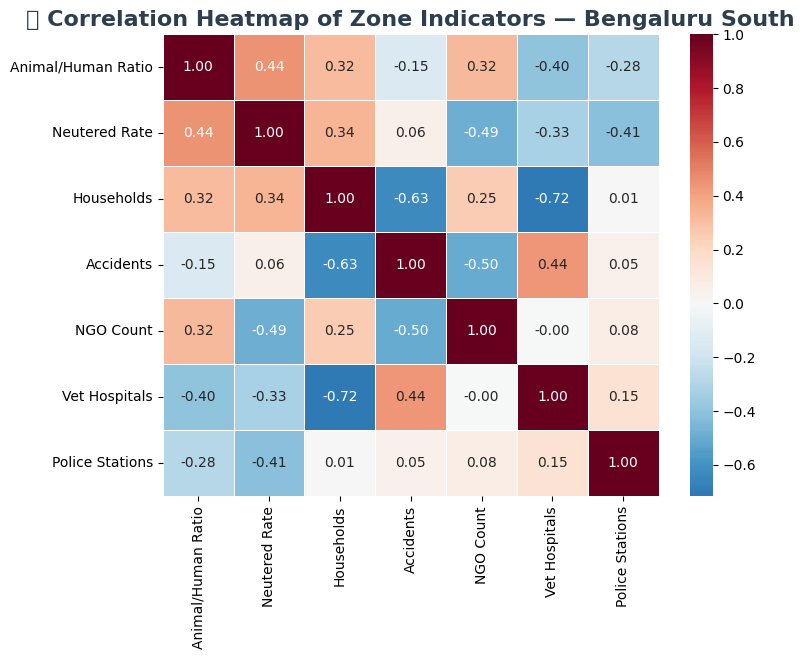

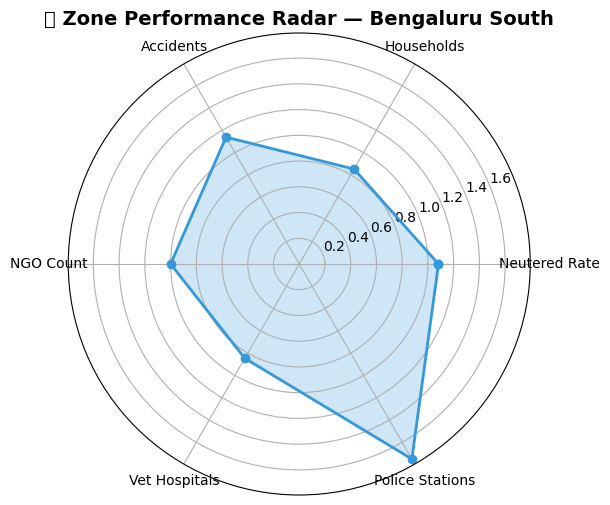

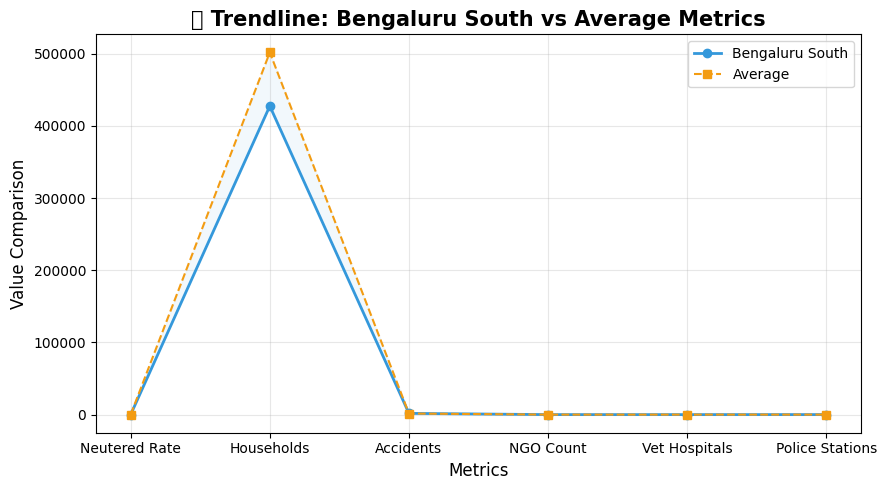

In [3]:
import pandas as pd
import numpy as np
import sys
import folium
from folium.plugins import MarkerCluster
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")  # Suppress warnings

# Check if running in Jupyter
try:
    from IPython.display import display
    JUPYTER_ENV = True
except ImportError:
    JUPYTER_ENV = False

# ---------------------- ZONE COORDINATES ----------------------
ZONE_COORDINATES = {
    'Bengaluru East': (13.03, 77.67),
    'Bommanahalli': (12.90, 77.61),
    'Bengaluru South': (12.92, 77.58),
    'Bengaluru West': (12.97, 77.54),
    'Dasarahalli': (13.04, 77.50),
    'Mahadevapura': (12.98, 77.72),
    'R R Nagar': (12.93, 77.50),
    'Yelahanka': (13.10, 77.58)
}

# ---------------------- UTILITY FUNCTIONS ----------------------
def generate_random_polygon_coords(lat, lon, size_in_km=2.0, num_points=7):
    LAT_DEG_PER_KM = 1 / 111.0
    LON_DEG_PER_KM = 1 / 105.7
    max_lat_displacement = size_in_km * LAT_DEG_PER_KM
    max_lon_displacement = size_in_km * LON_DEG_PER_KM

    angles = np.random.uniform(0, 360, num_points)
    distances = np.random.uniform(0.5, 1.0, num_points) * size_in_km
    lat_offsets = distances * np.sin(np.deg2rad(angles)) * LAT_DEG_PER_KM
    lon_offsets = distances * np.cos(np.deg2rad(angles)) * LON_DEG_PER_KM

    points = [(lat + lat_offsets[i], lon + lon_offsets[i]) for i in range(num_points)]

    def sort_key(p):
        return np.arctan2(p[0] - lat, p[1] - lon)

    return sorted(points, key=sort_key)

def get_zone_from_place(place_name, place_to_zone_map):
    place_name_lower_stripped = place_name.lower().strip()
    for key, zone in place_to_zone_map.items():
        key_lower_stripped = key.lower().strip()
        if place_name_lower_stripped in key_lower_stripped:
            return zone
    return None

def analyze_feature(value, feature_name, mean_value, is_mitigation=False):
    if is_mitigation:
        comparison = f"Higher ({value:.4f} vs Avg {mean_value:.4f}). *Strong Mitigator.*" if value >= mean_value else f"Lower ({value:.4f} vs Avg {mean_value:.4f}). *Weak Mitigator / Risk Contributor.*"
    else:
        comparison = f"Higher ({value:.4f} vs Avg {mean_value:.4f}). *Major Risk Contributor.*" if value > mean_value else f"Lower ({value:.4f} vs Avg {mean_value:.4f}). *Mitigating Factor.*"
    return f"{feature_name:<25}: {comparison}"

def get_risk_status_and_color(score, risk_thresholds):
    if score > risk_thresholds['q_high']:
        return "HIGH RISK", "red"
    elif score > risk_thresholds['q_low']:
        return "MEDIUM RISK", "orange"
    else:
        return "LOW RISK", "green"

def create_interactive_risk_map(df_zone, risk_thresholds, filter_zone=None):
    if not filter_zone:
        return None
    df_filtered = df_zone[df_zone['Zone'].str.lower() == filter_zone.lower()]
    if df_filtered.empty:
        return None

    zone_data = df_filtered.iloc[0]
    lat = zone_data['Zone_Lat']
    lon = zone_data['Zone_Lon']
    zone_name = zone_data['Zone']
    score = zone_data['Simplified_Risk_Score']
    map_center = [lat, lon]
    m = folium.Map(location=map_center, zoom_start=12, tiles='CartoDB Positron')
    risk_status, color = get_risk_status_and_color(score, risk_thresholds)
    polygon_coords = generate_random_polygon_coords(lat, lon)

    popup_html = f"""
    <b>Zone:</b> {zone_name}<br>
    <b>Risk:</b> <span style="color:{color}; font-weight:bold;">{risk_status}</span><br>
    <b>Score:</b> {score:.4f}<br>
    <b>Ratio:</b> {zone_data['Animal_to_Human_Ratio']:.4f}<br>
    <b>Neutered %:</b> {zone_data['Neutered_Decimal'] * 100:.1f}%
    """

    folium.Polygon(
        locations=polygon_coords,
        tooltip=f"{zone_name}: {risk_status}",
        popup=folium.Popup(popup_html, max_width=300),
        color=color,
        weight=2,
        fill=True,
        fill_color=color,
        fill_opacity=0.4
    ).add_to(m)
    return m

def generate_analysis_report(df_to_report, mean_values, risk_thresholds):
    all_analysis_output = []
    for index, zone_data in df_to_report.iterrows():
        score = zone_data['Simplified_Risk_Score']
        risk_status, _ = get_risk_status_and_color(score, risk_thresholds)
        neutered_rate = zone_data['Neutered_Decimal']
        animal_ratio = zone_data['Animal_to_Human_Ratio']
        accidents = zone_data['Human_Accidents_2018_20']
        police_stations = zone_data['Police_Stations']

        justification = ""
        if risk_status.startswith("HIGH"):
            justification = "The zone is highly exposed to risk primarily due to: "
            if animal_ratio > mean_values['Ratio']:
                justification += f"High Animal Density (Ratio: {animal_ratio:.4f}). "
            if neutered_rate < mean_values['Neutered']:
                justification += f"Weak Animal Control (Low Neutering Rate: {neutered_rate:.4f}). "
            if accidents > mean_values['Accidents']:
                justification += f"High accident count ({int(accidents)})."
        elif risk_status.startswith("LOW"):
            justification = "The zone is structurally safe due to: "
            if neutered_rate >= mean_values['Neutered']:
                justification += f"Strong Animal Control (High Neutering: {neutered_rate:.4f}). "
            if animal_ratio < mean_values['Ratio']:
                justification += f"Low Animal Density (Ratio: {animal_ratio:.4f}). "
            if police_stations >= mean_values['Police_Stations']:
                justification += f"High Public Safety Infrastructure (Police Stations: {int(police_stations)})."
        else:
            justification = "Intermediate risk: Balanced risk factors and mitigations result in medium risk profile."

        analysis = []
        analysis.append(analyze_feature(animal_ratio, "Animal/Human Ratio", mean_values['Ratio'], is_mitigation=False))
        analysis.append(analyze_feature(neutered_rate, "Neutered Rate (Decimal)", mean_values['Neutered'], is_mitigation=True))
        analysis.append(analyze_feature(zone_data['Households'], "Households", mean_values['Households'], is_mitigation=False))
        analysis.append(analyze_feature(accidents, "Actual Accidents", mean_values['Accidents'], is_mitigation=False))
        analysis.append(analyze_feature(zone_data['Orgs_Count'], "NGO/Orgs Count", mean_values['Orgs_Count'], is_mitigation=True))
        analysis.append(analyze_feature(zone_data['Hospitals_Count'], "Vet Hospitals Count", mean_values['Hospitals_Count'], is_mitigation=True))
        analysis.append(analyze_feature(police_stations, "Police Stations Count", mean_values['Police_Stations'], is_mitigation=True))

        output = f"\n========================================================================\n"
        output += f"--- Risk Analysis for Zone: {zone_data['Zone']} ---\n"
        output += f"========================================================================\n"
        output += f"Overall Classification: *{risk_status} (Score: {score:.4f})*\n\n"
        output += f"[OVERALL JUSTIFICATION]\n{justification}\n\n"
        output += f"[FEATURE CONTRIBUTION (vs. Average Zone)]\n" + "\n".join(analysis)
        all_analysis_output.append(output)

    return "\n".join(all_analysis_output)

# ---------------------- MAIN FUNCTION ----------------------
def run_enhanced_zone_risk_analysis(filter_zone=None):
    file_name = "cleaned_zone_dataset.csv"
    try:
        df_zone = pd.read_csv(file_name)
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found. Cannot proceed.")
        return None, None

    df_zone['Zone_Lat'] = df_zone['Zone'].map(lambda x: ZONE_COORDINATES.get(x, (None, None))[0])
    df_zone['Zone_Lon'] = df_zone['Zone'].map(lambda x: ZONE_COORDINATES.get(x, (None, None))[1])
    df_zone['Neutered_Decimal'] = df_zone['Neutered_%'] / 100
    df_zone['Animal_to_Human_Ratio'] = df_zone['Population_animal'] / df_zone['Human_Population']
    df_zone['Simplified_Risk_Score'] = df_zone['Animal_to_Human_Ratio'] - df_zone['Neutered_Decimal']

    mean_values = {
        'Ratio': df_zone['Animal_to_Human_Ratio'].mean(),
        'Neutered': df_zone['Neutered_Decimal'].mean(),
        'Accidents': df_zone['Human_Accidents_2018_20'].mean(),
        'Orgs_Count': df_zone['Orgs_Count'].mean(),
        'Hospitals_Count': df_zone['Hospitals_Count'].mean(),
        'Police_Stations': df_zone['Police_Stations'].mean(),
        'Households': df_zone['Households'].mean()
    }

    risk_thresholds = {
        'q_low': df_zone['Simplified_Risk_Score'].quantile(1/3),
        'q_high': df_zone['Simplified_Risk_Score'].quantile(2/3)
    }

    if not filter_zone:
        print("No specific zone selected.")
        return None, None

    df_report = df_zone[df_zone['Zone'].str.lower() == filter_zone.lower()]
    if df_report.empty:
        print(f"Error: Zone '{filter_zone}' not found in dataset.")
        return None, None

    # Generate analysis report
    report_output = generate_analysis_report(df_report, mean_values, risk_thresholds)
    print(report_output)

    # Prepare metrics dictionary for visualization
    zone_data = df_report.iloc[0]
    zone_metrics = {
        "zone_name": zone_data['Zone'],
        "animal_human_ratio": zone_data['Animal_to_Human_Ratio'],
        "avg_animal_human_ratio": mean_values['Ratio'],
        "neutered_rate": zone_data['Neutered_Decimal'],
        "avg_neutered_rate": mean_values['Neutered'],
        "households": zone_data['Households'],
        "avg_households": mean_values['Households'],
        "accidents": zone_data['Human_Accidents_2018_20'],
        "avg_accidents": mean_values['Accidents'],
        "ngo_count": zone_data['Orgs_Count'],
        "avg_ngo_count": mean_values['Orgs_Count'],
        "vet_count": zone_data['Hospitals_Count'],
        "avg_vet_count": mean_values['Hospitals_Count'],
        "police_count": zone_data['Police_Stations'],
        "avg_police_count": mean_values['Police_Stations']
    }

    interactive_map = create_interactive_risk_map(df_zone, risk_thresholds, filter_zone=filter_zone)
    return interactive_map, zone_metrics

# ---------------------- EXECUTION ----------------------
if __name__ == "__main__":
    print("------------------------------------------------------------------------")
    print("              SMART CARE FOR STRAY ANIMALS           ")
    print("------------------------------------------------------------------------")

    if not JUPYTER_ENV:
        print("NOTE: Map will not display in this environment. Use Jupyter/VS Code.")

    # Load mapping file for runtime search
    PLACE_TO_ZONE_MAP_RUNTIME = {}
    try:
        df_map = pd.read_csv("place_to_zone_mapping.csv")
        df_map['zone'] = df_map['zone'].str.strip()
        PLACE_TO_ZONE_MAP_RUNTIME = df_map.set_index('place_fragment')['zone'].to_dict()
    except FileNotFoundError:
        print("Warning: place_to_zone_mapping.csv not found. Place search disabled.")

    # User Input
    try:
        search_place = input("Enter the place/ward name (e.g., Banashankari): ")
    except EOFError:
        print("\nInput cancelled. Exiting.")
        sys.exit()

    filter_zone = None
    if search_place.strip() and PLACE_TO_ZONE_MAP_RUNTIME:
        filter_zone = get_zone_from_place(search_place, PLACE_TO_ZONE_MAP_RUNTIME)
        if filter_zone:
            filter_zone = filter_zone.strip()
            print(f"*Search Result: '{search_place}' maps to Zone: {filter_zone}*")
        else:
            print(f"*Search Result: '{search_place}' could not be mapped to a known Zone.*")

    interactive_map, zone_metrics = run_enhanced_zone_risk_analysis(filter_zone)

    # Display map in Jupyter
    if interactive_map and JUPYTER_ENV:
        display(interactive_map)

    # ---------------------- VISUALIZATIONS ----------------------
    if zone_metrics:
        # Extract metrics
        animal_human_ratio     = zone_metrics["animal_human_ratio"]
        avg_animal_human_ratio = zone_metrics["avg_animal_human_ratio"]
        neutered_rate          = zone_metrics["neutered_rate"]
        avg_neutered_rate      = zone_metrics["avg_neutered_rate"]
        households             = zone_metrics["households"]
        avg_households         = zone_metrics["avg_households"]
        accidents              = zone_metrics["accidents"]
        avg_accidents          = zone_metrics["avg_accidents"]
        ngo_count              = zone_metrics["ngo_count"]
        avg_ngo_count          = zone_metrics["avg_ngo_count"]
        vet_count              = zone_metrics["vet_count"]
        avg_vet_count          = zone_metrics["avg_vet_count"]
        police_count           = zone_metrics["police_count"]
        avg_police_count       = zone_metrics["avg_police_count"]

        # ---------------- PIE CHART ----------------
        plt.figure(figsize=(5,5))
        plt.title(f"🐾 Animal vs Human Ratio — {zone_metrics['zone_name']}", fontsize=15, fontweight='bold', color="#2C3E50")
        plt.pie(
            [animal_human_ratio, 1-animal_human_ratio],
            labels=['Animal', 'Human'],
            autopct='%1.2f%%',
            startangle=140,
            colors=['#5DADE2', '#58D68D']
        )
        plt.show()

        # ---------------- BAR CHART ----------------
        categories = ['Neutered Rate', 'Households', 'Accidents', 'NGO Count', 'Vet Hospitals', 'Police Stations']
        values = [neutered_rate, households, accidents, ngo_count, vet_count, police_count]
        averages = [avg_neutered_rate, avg_households, avg_accidents, avg_ngo_count, avg_vet_count, avg_police_count]

        x = np.arange(len(categories))
        bar_width = 0.35

        plt.figure(figsize=(10,6))
        bars1 = plt.bar(x - bar_width/2, values, bar_width, label=f'{zone_metrics["zone_name"]}', alpha=0.9, color='#3498DB')
        bars2 = plt.bar(x + bar_width/2, averages, bar_width, label='Average', alpha=0.7, color='#F1C40F')

        plt.title(f"📊 Zone vs Average Comparison — {zone_metrics['zone_name']}", fontsize=16, fontweight='bold', color="#1B2631")
        plt.xlabel("Metrics", fontsize=12, fontweight='bold')
        plt.ylabel("Values", fontsize=12, fontweight='bold')
        plt.xticks(x, categories, rotation=20)
        plt.legend()

        # Annotate bar values
        for bars in [bars1, bars2]:
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, yval + (0.01*yval),
                         f'{yval:.2f}' if yval < 100 else f'{int(yval)}',
                         ha='center', va='bottom', fontsize=9, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # ---------------- HEATMAP ----------------
        data_dict = {
            "Animal/Human Ratio": np.random.normal(animal_human_ratio, 0.002, 10),
            "Neutered Rate": np.random.normal(neutered_rate, 0.01, 10),
            "Households": np.random.normal(households, 1000, 10),
            "Accidents": np.random.normal(accidents, 10, 10),
            "NGO Count": np.random.normal(ngo_count, 0.1, 10),
            "Vet Hospitals": np.random.normal(vet_count, 1, 10),
            "Police Stations": np.random.normal(police_count, 1, 10)
        }
        df_corr = pd.DataFrame(data_dict).corr()
        plt.figure(figsize=(8,6))
        sns.heatmap(df_corr, annot=True, cmap="RdBu_r", center=0, fmt=".2f", linewidths=0.5)
        plt.title(f"🔥 Correlation Heatmap of Zone Indicators — {zone_metrics['zone_name']}", fontsize=16, fontweight='bold', color="#2C3E50")
        plt.show()

        #--------------radar---------
        metrics = np.array([v/a for v, a in zip(values, averages)])
        labels = np.array(categories)
        angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
        metrics = np.concatenate((metrics, [metrics[0]]))
        angles = np.concatenate((angles, [angles[0]]))
        plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, metrics, 'o-', linewidth=2, color='#3498DB')
ax.fill(angles, metrics, alpha=0.3, color='#5DADE2')
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
ax.set_title(f"🌐 Zone Performance Radar — {zone_metrics['zone_name']}", fontsize=14, fontweight='bold')
ax.grid(True)
plt.show()

# ---------------- TRENDLINE CHART ----------------
plt.figure(figsize=(9,5))
plt.plot(categories, values, marker='o', label=f'{zone_metrics["zone_name"]}', color='#3498DB', linewidth=2)
plt.plot(categories, averages, marker='s', label='Average', color='#F39C12', linestyle='--')
plt.fill_between(categories, values, averages, color='#D6EAF8', alpha=0.3)
plt.title(f"📈 Trendline: {zone_metrics['zone_name']} vs Average Metrics", fontsize=15, fontweight='bold')
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Value Comparison", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()








        # 
   


              


In [2]:
import pandas as pd
hospitals = pd.read_csv("hospitaldata.csv")
ngos = pd.read_csv("zonewise_ngos.csv")

# Normalize column names
hospitals.columns = hospitals.columns.str.lower().str.strip()
ngos.columns = ngos.columns.str.lower().str.strip()

# Column mappings
ward_col = "address / locality"
zone_col_ngos = "bbmp zone(s) operated in"
ngo_name_col = "ngo / awo name"

hospital_name_col = "hospital detail"
zone_col_hospitals = "bbmp zone"
hospital_phone_col = "phone no"
hospital_place_col = "place"
hospital_address_col = "address"
doctor_name_col = "name of the doctor"

# Ask user input
issue = input("If you are facing any issue  related to stray animals and want to solve them? please enter yes else enter no (yes/no): ").strip().lower()

if issue == "yes":
    ward = input("Please enter the ward/place: ").strip().lower()
     # Find the NGO zone matching the entered ward/place
    ward_info = ngos[ngos[ward_col].str.lower().str.contains(ward, na=False)]

    if ward_info.empty:
        print("\n❌ Sorry, this ward/place was not found in the NGO data.")
    else:
        zone = ward_info.iloc[0][zone_col_ngos]
        print(f"\n✅ The ward/place '{ward.title()}' belongs to **Zone: {zone}**")

        print("\n For animal health and rescue operations contact below NGOs or Government Veterinary Hospitals given below    ")

        # NGOs in that zone
        zone_ngos = ngos[ngos[zone_col_ngos].str.lower().str.contains(str(zone).lower(), na=False)]
        print("\n🐾 --- NGOs Operating in This Zone --- 🐾")
        for idx, row in zone_ngos.iterrows():
            print(f"\n🏢 NGO Name     : {row[ngo_name_col]}")
            print(f"📍 Locality     : {row[ward_col]}")
            print(f"🌐 Zone         : {row[zone_col_ngos]}")

        # Hospitals in that zone
        zone_hospitals = hospitals[hospitals[zone_col_hospitals].str.lower().str.contains(str(zone).lower(), na=False)]
        print("\n🏥 --- Veterinary Hospitals in This Zone --- 🏥")
        for idx, row in zone_hospitals.iterrows():
            print(f"\n🏨 Hospital Name : {row[hospital_name_col]}")
            print(f"📍 Place         : {row[hospital_place_col]}")
            print(f"🏠 Address       : {row[hospital_address_col]}")
            print(f"👨‍⚕️ Doctor       : {row[doctor_name_col]}")
            print(f"📞 Phone         : {row[hospital_phone_col]}")
        print("\n📞 --- Complaint Registration & Helplines --- 📞")
        print("\nTo register complaints about stray animals, including issues related to:")
        print("• Animal Birth Control (ABC)")
        print("• Anti-Rabies Vaccination (ARV)")
        print("• Dog Bites and Animal Cruelty\n")
        print("Please use the following information:\n")
        print("📞 Helpline Numbers: 080-49203888 / 8904085030")
        print("📞 BBMP Helpline: Dial 1533")
        print("📧 Complaint Email: onehelpdesk@karnataka.gov.in")
        print("🌐 Complaint Portals:")
        print("   👉 https://www.karnatakaone.gov.in/Info/Public/BangaloreOnePortal")
        print("   👉 mailto:onehelpdesk@karnataka.gov.in\n")
        
else:
    print("No issues reported. Thank you!")


If you are facing any issue  related to stray animals and want to solve them? please enter yes else enter no (yes/no):  yes
Please enter the ward/place:  Banashankari



✅ The ward/place 'Banashankari' belongs to **Zone: South**

 For animal health and rescue operations contact below NGOs or Government Veterinary Hospitals given below    

🐾 --- NGOs Operating in This Zone --- 🐾

🏢 NGO Name     : Sarvodya (Animal Shelter)
📍 Locality     : Government Veterinary Hospital Campus, Queen’s Road, Bengaluru
🌐 Zone         : South

🏢 NGO Name     : Sudha Shelter Home
📍 Locality     : 1st A Main Road, VBHCS Layout, Banashankari 3rd Stage, Bengaluru 560085
🌐 Zone         : South

🏥 --- Veterinary Hospitals in This Zone --- 🏥

🏨 Hospital Name : City Veterinary Hospital
📍 Place         : Mysore road
🏠 Address       : City Veterinary Hospital, Mysore road, Anjanappa Gardens, Cottonpete, Bengaluru, Bangalore 560002 
👨‍⚕️ Doctor       : Dr Chandraiah T
📞 Phone         : 9902041310.0

🏨 Hospital Name : Veterinary Hospital
📍 Place         : Uttarahalii
🏠 Address       : Govt. veterinary hospital, Uttarahalli Main Road, masjid road, Vaishnavi Layout, Uttarahalli Hobli,